In [30]:
from importlib import reload
import flymovie as fm
import cnn_models.siamese_cnn as cn
import cnn_models.evaluate_models as ev
from flymovie.simnuc import Sim
import matplotlib.pyplot as plt
import numpy as np
import os
import pickle
import tensorflow as tf
from importlib import reload
import scipy.ndimage as ndi
import skimage as ski
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [275]:
im = fm.read_czi('/Users/michaelstadler/Bioinformatics/Projects/rpb1/data/counting_blobs/cycle 12/embryo17.czi', swapaxes=False)
fm.viewer(im, 5)

interactive(children=(Dropdown(description='Color', index=10, options=('gray', 'Gators', 'Greens', 'prism', 'v…

In [276]:
# Segment real nuclei from here.
thresh = 25
nucs = []
sm = ndi.gaussian_filter(im, (2,5,5))
mask = np.where(sm >= thresh, 1, 0)
lmask, _ = ndi.label(mask)
regions = regionprops(lmask)
for n in range(0, len(regions)):
    centroid = [int(x) for x in regions[n].centroid]
    i, j = centroid[1:]
    start_i = i - 50
    end_i = i + 50
    start_j = j - 50
    end_j = j + 50
    if ((start_i >= 0) & (start_j >= 0) & (end_i <= lmask.shape[1]) & (end_j <= lmask.shape[2])):
        nuc = im[5:39, start_i:end_i, start_j:end_j]
        nucmask = mask[5:39, start_i:end_i, start_j:end_j]
        nuc = np.where(nucmask, nuc, 0)
        nucs.append(nuc)
        


In [7]:
weights_file = '/Users/michaelstadler/Bioinformatics/Projects/rpb1/results/gridsearch/checkpoint_final_8epochs_easytomedium_plus_8x99.9'
base_cnn = cn.make_base_cnn_3d(image_shape=(34,100,100), nlayers=8)
embedding = cn.make_embedding(base_cnn)
embedding.load_weights(weights_file)

2022-03-14 12:26:57.442705: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [8]:
def embed_list(ims, embedding):
    e = np.ndarray((0,256))
    for im in ims:
        im = im.astype('float32')
        # Dummy axis must be added in position 0.
        im = np.expand_dims(im, axis=-1)
        # Normalize 0-1.
        im = (im - np.min(im)) / (np.max(im) - np.min(im))
        im_e = embedding(im).numpy()
        e = np.vstack([e, im_e])
    return e


In [336]:
import sklearn.decomposition
def pca3d(embeddings, alpha=1, use_combined=False):
    combined = np.vstack(embeddings)
    pca = sklearn.decomposition.PCA(n_components=3)
    if use_combined:
        pca.fit(combined)
    else:
        pca.fit(embeddings[0])
    fig = plt.figure(figsize=plt.figaspect(0.5))
    ax = fig.add_subplot(1, 1, 1, projection='3d')
    for i in range(len(embeddings)):
        if i == 0:
            alpha_plot = 0
        else:
            alpha_plot = alpha
        tfm = pca.transform(embeddings[i])
        ax.scatter(tfm[:,0], tfm[:,1], tfm[:,2], 
                alpha=alpha_plot)
    

In [10]:
from cnn_models.siamese_cnn import preprocess_image
def preprocess_image_py(file):
    [im,] = tf.py_function(preprocess_image,[file,],[tf.float32,])
    return im

def make_ds(folder):
    im_files = []
    for f in os.listdir(folder):
        if f[0] == '.':
            continue
        im_files.append(os.path.join(folder, f))
    
    dataset = tf.data.Dataset.from_tensor_slices(im_files)
    dataset = dataset.map(preprocess_image_py, num_parallel_calls=tf.data.AUTOTUNE)
    dataset = dataset.prefetch(tf.data.AUTOTUNE)
    return dataset

ds = make_ds('/Users/michaelstadler/Bioinformatics/Projects/rpb1/data/siamese_eval_datasets/rpb1_wide_UTkaWAfT/left')

In [11]:
embeddings_base, params_base = fm.load_pickle('/Users/michaelstadler/Bioinformatics/Projects/rpb1/results/8epochs_easytomedium_plus_8x99.9_left_embeddings.pkl')

Some ideas:
- Do some modifications to real data to make them look more like fake images (add noise, deconvolve, reconvolve)
- Train with a mix of real and fake data (real-real comparisons, fake-fake comparisons)
- Include some real-fake *similar* pairs hand-tuned to be similar according to moi.
-

In [12]:
def save_list(l, outfolder):
    if not os.path.exists(outfolder):
        os.mkdir(outfolder)
    count = 1
    for arr in l:
        
        fake_id = 'aaa_'
        fake_params = [str(round(x, 2)) for x in np.random.random(9)]
        filepath = os.path.join(outfolder, fake_id + '_'.join(fake_params) + '.pkl')
        fm.save_pickle(arr, filepath)
        count += 1

#save_list(nucs_mod, '/Users/michaelstadler/Bioinformatics/Projects/rpb1/results/realnucs_mod')

In [13]:
nucs_mod = []
sigma = 100
for nuc in nucs:
    #nuc_mod = nuc + np.random.poisson(nuc)
    gaussian = np.random.normal(np.zeros_like(nuc), scale=sigma)
    nucs_mod.append(nuc + gaussian)

save_list(nucs_mod, '/Users/michaelstadler/Bioinformatics/Projects/rpb1/results/realnucs_mod')


In [14]:
e, _ = ev.embed_images('/Users/michaelstadler/Bioinformatics/Projects/rpb1/results/realnucs_test', embedding)

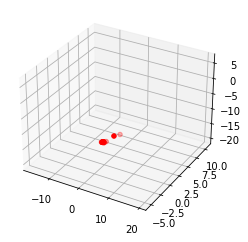

In [15]:
pca3d(embeddings_base, e, 0.0001)

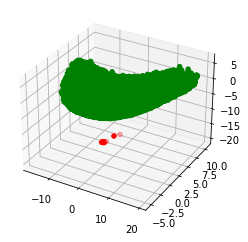

In [16]:
pca3d(embeddings_base, e, 1)

OK, it's all in the training data. There are basically two directions:

1) Make simulated images more similar to real images (eliminate peculiarities)
2) Add real images to training data

I think I should try both. Plan:

1) Modify simulations to remove artificial artifacts (circles in center, zero background, etc.)
2) Hand-tune some simulations to match real nuclei

Make training sets of like 5_000, do a handful of epochs, see if real images embed amidst fake ones.




In [17]:
def load_folder(folder):
    ims = []
    for f in sorted(os.listdir(folder)):
        if f[0] == '.':
            continue
        im = fm.load_pickle(os.path.join(folder, f))
        ims.append(im)
    return ims

In [18]:
ims = load_folder('/Users/michaelstadler/Bioinformatics/Projects/rpb1/results/fakesims_bigger_SJZCxOjT/left')
fake = np.array(ims)
real = np.array(nucs)
real = real * np.mean(fake) / np.mean(real)



In [19]:
fake_z = []
for im in fake:
    fake_z.append(im[:,18:-22,18:-22])

In [74]:
save_list(fake_z, '/Users/michaelstadler/Bioinformatics/Projects/rpb1/data/simulations/fakes/fakes_zoom_2pxloffcenter')

In [66]:
centered = load_folder('/Users/michaelstadler/Bioinformatics/Projects/rpb1/data/simulations/fakes/fakes_zoom_center')
off1 = load_folder('/Users/michaelstadler/Bioinformatics/Projects/rpb1/data/simulations/fakes/fakes_zoom_1pxloffcenter')
off5 = load_folder('/Users/michaelstadler/Bioinformatics/Projects/rpb1/data/simulations/fakes/fakes_zoom_5pxloffcenter')

In [67]:
fm.viewer(np.array(centered), 5)

interactive(children=(Dropdown(description='Color', index=8, options=('Greens', 'viridis', 'Gators', 'Reds', '…

In [68]:
fm.viewer(np.array(off1), 5)

interactive(children=(Dropdown(description='Color', index=8, options=('Greens', 'viridis', 'Gators', 'Reds', '…

In [77]:
e_centered, _ = ev.embed_images('/Users/michaelstadler/Bioinformatics/Projects/rpb1/data/simulations/fakes/fakes_zoom_center', embedding)
e_offcenter, _ = ev.embed_images('/Users/michaelstadler/Bioinformatics/Projects/rpb1/data/simulations/fakes/fakes_zoom_5pxloffcenter', embedding)

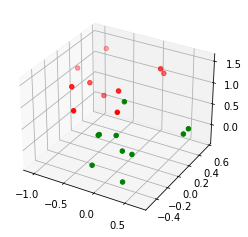

In [78]:
pca3d(e_centered, e_offcenter, 1)

In [20]:
mask = Sim.make_spherical_mask(100,100,100,42)
sim = Sim(mask)
eroded_coords = sim.get_eroded_coordinates(9)
hlb_possible_coords = list(zip(eroded_coords[0], eroded_coords[1], eroded_coords[2]))

In [365]:
sim.add_kernel('/Users/michaelstadler/Bioinformatics/Projects/rpb1/PSFs/psf_20220210_21x25x25pixels_100x50x50voxel.pkl', )


AttributeError: 'Sim' object has no attribute 'load_kernel'

In [21]:
def norm(im):
    return (im - np.min(im)) / (np.max(im) - np.min(im)) * (2 ** 16)

In [248]:
kernel=fm.load_pickle('/Users/michaelstadler/Bioinformatics/Projects/rpb1/PSFs/psf_20220210_21x25x25pixels_100x50x50voxel.pkl')
masks = [Sim.make_spherical_mask(100,100,100,45)]
outfolder = ''
nreps = 1
nfree_rng = [21_000, 21_000]
hlb_diam_rng = [14,14]
hlb_nmols_rng = [400,400]
n_clusters_rng = [55,55]
cluster_diam_mean_rng = [1,1] 
cluster_diam_var_rng = [0.1,0.1]
cluster_nmols_mean_rng = [13,13]
cluster_nmols_var_rng = [1.5,1.5]
noise_sigma_rng = [1,1]
dims_init=(85, 85, 85)
dims_kernel=(100,50,50)
dims_final=(250,85,85)

hlb_coords = [hlb_possible_coords[x] for x in np.random.choice(len(hlb_possible_coords), 2)]
#hlb_coords = [(12, 60, 38), (21, 57, 41)]
sims = []
for _ in range(5):
    sim = fm.sim_rpb1(masks, kernel, outfolder, nreps, nfree_rng, hlb_diam_rng, 
        hlb_nmols_rng, n_clusters_rng, cluster_diam_mean_rng, 
        cluster_diam_var_rng, cluster_nmols_mean_rng, cluster_nmols_var_rng,
        noise_sigma_rng, hlb_coords, dims_init, 
        dims_kernel, dims_final, return_sim=True, mask_nuclei=True)
    sims.append(sim.im)



In [250]:
fm.viewer([norm(nucs[1]), norm(sims[1])], 5)

interactive(children=(Dropdown(description='Color', index=10, options=('gray', 'Gators', 'Greens', 'prism', 'v…

In [75]:
fm.viewer([norm(fm.load_pickle('/Users/michaelstadler/Bioinformatics/Projects/rpb1/data/simulations/Rgl_20984_14.39_459_69_1_0.84_9_0.32_0.9_rep1.pkl')), norm(sim.im)],5)

interactive(children=(Dropdown(description='Color', index=10, options=('gray', 'Gators', 'Greens', 'prism', 'v…

In [28]:
fm.viewer(ndi.zoom(sim.mask, (2,2,2), order=0), 5)

interactive(children=(Dropdown(description='Color', index=10, options=('gray', 'Gators', 'Greens', 'prism', 'v…

In [52]:
#from skimage import regionprops
def extract_nuclei_tofile(stack, lmask, box_dims, sample_name, outfolder):
    def inbounds(im_shape, halflens, centroid):
        for dim in [1,2]:
            if centroid[dim] - halflens[dim] < 0:
                return False
            if centroid[dim] + halflens[dim] > im_shape[dim]:
                return False
        return True
    
    def get_box(stack, box_halflengths, box_dims, centroid, z):
        box = stack[
                    z:(z + box_dims[0]),
                    (centroid[1] - box_halflengths[1]):(centroid[1] + box_halflengths[1]),
                    (centroid[2] - box_halflengths[2]):(centroid[2] + box_halflengths[2])
                ]
        return box

    regions = ski.measure.regionprops(lmask)
    box_halflengths = (
            int(box_dims[0] / 2),
            int(box_dims[1] / 2),
            int(box_dims[2] / 2), 
        )
    count = 0
    for region in regions:
        centroid = ([round(x) for x in region.centroid])
        if inbounds(lmask.shape, box_halflengths, centroid):
            for z in range(lmask.shape[0] - box_dims[0]):
                outfilepath = os.path.join(outfolder, '_'.join([sample_name, str(count), str(z)]) + '.pkl')
                im_box = get_box(stack, box_halflengths, box_dims, centroid, z)
                #lmask_box = get_box(lmask, box_halflengths, box_dims, centroid, z)
                #im_box = np.where(lmask_box == region.label, im_box, 0)
                with open(outfilepath, 'wb') as outfile:
                    pickle.dump(im_box, outfile)
        count += 1

### Evaluating performance of model trained on mixed data

In [76]:
weights_file = '/Users/michaelstadler/Bioinformatics/Projects/rpb1/results/mixed_training/checkpoint_final_mix_real_sim_1'
base_cnn = cn.make_base_cnn_3d(image_shape=(34,100,100), nlayers=8)
embedding = cn.make_embedding(base_cnn)
embedding.load_weights(weights_file)

In [108]:
e_real = ev.embed_images('/Users/michaelstadler/Bioinformatics/Projects/rpb1/data/real_nuclei/all', embedding, return_params=False)

In [109]:
e_sims, _ = ev.embed_images('/Users/michaelstadler/Bioinformatics/Projects/rpb1/results/fakesims_mixwithreal_aGdSCuwy/left', embedding)

In [110]:
e_zld = ev.embed_images('/Users/michaelstadler/Bioinformatics/Projects/rpb1/data/real_nuclei/zld', embedding, return_params=False)
e_rpb1 = ev.embed_images('/Users/michaelstadler/Bioinformatics/Projects/rpb1/data/real_nuclei/rpb1', embedding, return_params=False)
e_h2b = ev.embed_images('/Users/michaelstadler/Bioinformatics/Projects/rpb1/data/real_nuclei/h2b', embedding, return_params=False)

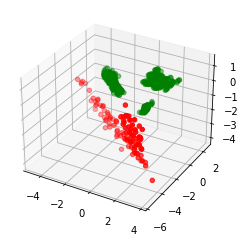

In [138]:
pca3d(e_real, e_sims, 0.5, use_combined=False)

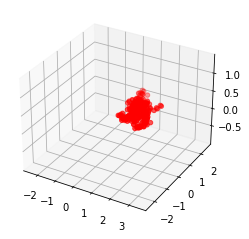

In [124]:
pca3d(e_real, e_zld, 0)

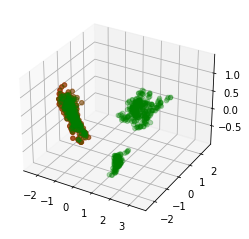

In [133]:
pca3d(e_real, e_h2b, 0.3)

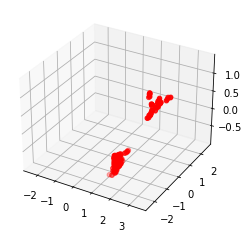

In [125]:
pca3d(e_real, e_rpb1, 0)

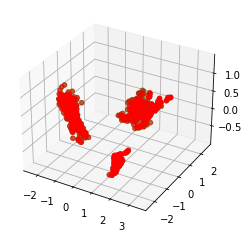

In [131]:
pca3d(e_real, e_real, 0.5)

Two lists. For each item in list, get distance to all in own list and all in second list. Count how many in list 2 are closer than farthest in own list or mean own dist.



In [214]:
def rankdiff(arr_self, arr_other):
    fxns_farthest = []
    fxns_mean = []
    for row in arr_self:
        dists_self = np.sum((arr_self - row) ** 2, axis=1)
        dists_other = np.sum((arr_other - row) ** 2, axis=1)
        mean_dist_self = np.mean(dists_self)
        max_dist_self = np.max(dists_self)
        
        fxns_farthest.append(np.count_nonzero(dists_other <= max_dist_self) / len(dists_other))
        fxns_mean.append(np.count_nonzero(dists_other <= mean_dist_self) / len(dists_other))

    return fxns_farthest, fxns_mean
    

def embed_list(l, embedding):
    with tempfile.TemporaryDirectory() as tempdir:
        save_list(l, tempdir)
        e = ev.embed_images(tempdir, embedding, return_params=False)
    return e

farthest, mean_ = rankdiff(e_rpb1, e_sims)
print(np.mean(mean_))
print(np.mean(farthest))

0.0
0.007379310344827587


In [244]:
e_fakes = ev.embed_images('/Users/michaelstadler/Bioinformatics/Projects/rpb1/results/rpb1-handfakes', embedding, return_params=False)
e_fakes_masked = ev.embed_images('/Users/michaelstadler/Bioinformatics/Projects/rpb1/results/rpb1-handfakes-masked', embedding, return_params=False)
e_reals = ev.embed_images('/Users/michaelstadler/Bioinformatics/Projects/rpb1/results/rpb1-real-matchhandfakes', embedding, return_params=False)
e_reals_masked = ev.embed_images('/Users/michaelstadler/Bioinformatics/Projects/rpb1/results/rpb1-real-matchhandfakes-masked', embedding, return_params=False)

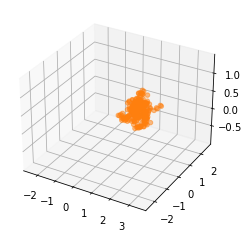

In [342]:
pca3d([e_all, e_zld], 0.5)

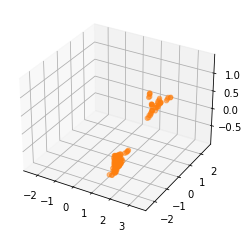

In [341]:
pca3d([e_all, e_rpb1], 0.5)

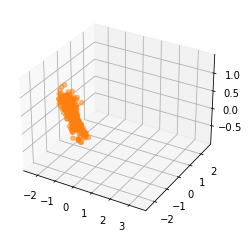

In [343]:
pca3d([e_all, e_h2b], 0.5)

In [345]:
farthest, mean_ = rankdiff(e_rpb1, e_reals_masked)
print(np.mean(mean_))
print(np.mean(farthest))

0.3963702359346642
0.8722323049001814


In [323]:
kernel=fm.load_pickle('/Users/michaelstadler/Bioinformatics/Projects/rpb1/PSFs/psf_20220210_21x25x25pixels_100x50x50voxel.pkl')
masks = [Sim.make_spherical_mask(100,100,100,45)]
outfolder = ''
nreps = 1
nfree_rng = [15_000, 15_000]
hlb_diam_rng = [14,14]
hlb_nmols_rng = [550,550]
n_clusters_rng = [55,55]
cluster_diam_mean_rng = [1,1] 
cluster_diam_var_rng = [0.1,0.1]
cluster_nmols_mean_rng = [13,13]
cluster_nmols_var_rng = [1.5,1.5]
noise_sigma_rng = [1,1]
dims_init=(85, 85, 85)
dims_kernel=(100,50,50)
dims_final=(250,85,85)

hlb_coords = [hlb_possible_coords[x] for x in np.random.choice(len(hlb_possible_coords), 2)]
#hlb_coords = [(12, 60, 38), (21, 57, 41)]
sims = []
for _ in range(2):
    sim = fm.sim_rpb1(masks, kernel, outfolder, nreps, nfree_rng, hlb_diam_rng, 
        hlb_nmols_rng, n_clusters_rng, cluster_diam_mean_rng, 
        cluster_diam_var_rng, cluster_nmols_mean_rng, cluster_nmols_var_rng,
        noise_sigma_rng, hlb_coords, dims_init, 
        dims_kernel, dims_final, return_sim=True, mask_nuclei=True)
    sims.append(sim.im)

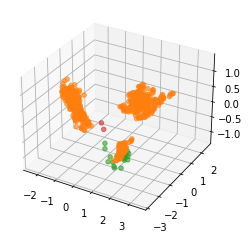

In [354]:
kernel=fm.load_pickle('/Users/michaelstadler/Bioinformatics/Projects/rpb1/PSFs/psf_20220210_21x25x25pixels_100x50x50voxel.pkl')
masks = [Sim.make_spherical_mask(100,100,100,45)]
outfolder = ''
nreps = 1
nfree_rng = [15_000, 15_000]
hlb_diam_rng = [14,14]
hlb_nmols_rng = [1,1]
n_clusters_rng = [1055,1055]
cluster_diam_mean_rng = [1,1] 
cluster_diam_var_rng = [0.1,0.1]
cluster_nmols_mean_rng = [13,13]
cluster_nmols_var_rng = [1.5,1.5]
noise_sigma_rng = [1,1]
dims_init=(85, 85, 85)
dims_kernel=(100,50,50)
dims_final=(250,85,85)

hlb_coords = [hlb_possible_coords[x] for x in np.random.choice(len(hlb_possible_coords), 2)]
#hlb_coords = [(12, 60, 38), (21, 57, 41)]
sims = []
for _ in range(2):
    sim = fm.sim_rpb1(masks, kernel, outfolder, nreps, nfree_rng, hlb_diam_rng, 
        hlb_nmols_rng, n_clusters_rng, cluster_diam_mean_rng, 
        cluster_diam_var_rng, cluster_nmols_mean_rng, cluster_nmols_var_rng,
        noise_sigma_rng, hlb_coords, dims_init, 
        dims_kernel, dims_final, return_sim=True, mask_nuclei=True)
    sims.append(sim.im)

e_fakes = embed_list(sims, embedding)
pca3d([e_all, e_all, e_reals_masked, e_fakes], 0.6)
#plt.savefig('/Users/michaelstadler/Documents/presentations/groupmeetings/20220316/output.png', dpi=500)

In [355]:
fm.viewer(sims[0], 5)

interactive(children=(Dropdown(description='Color', index=10, options=('gray', 'Gators', 'Greens', 'prism', 'v…

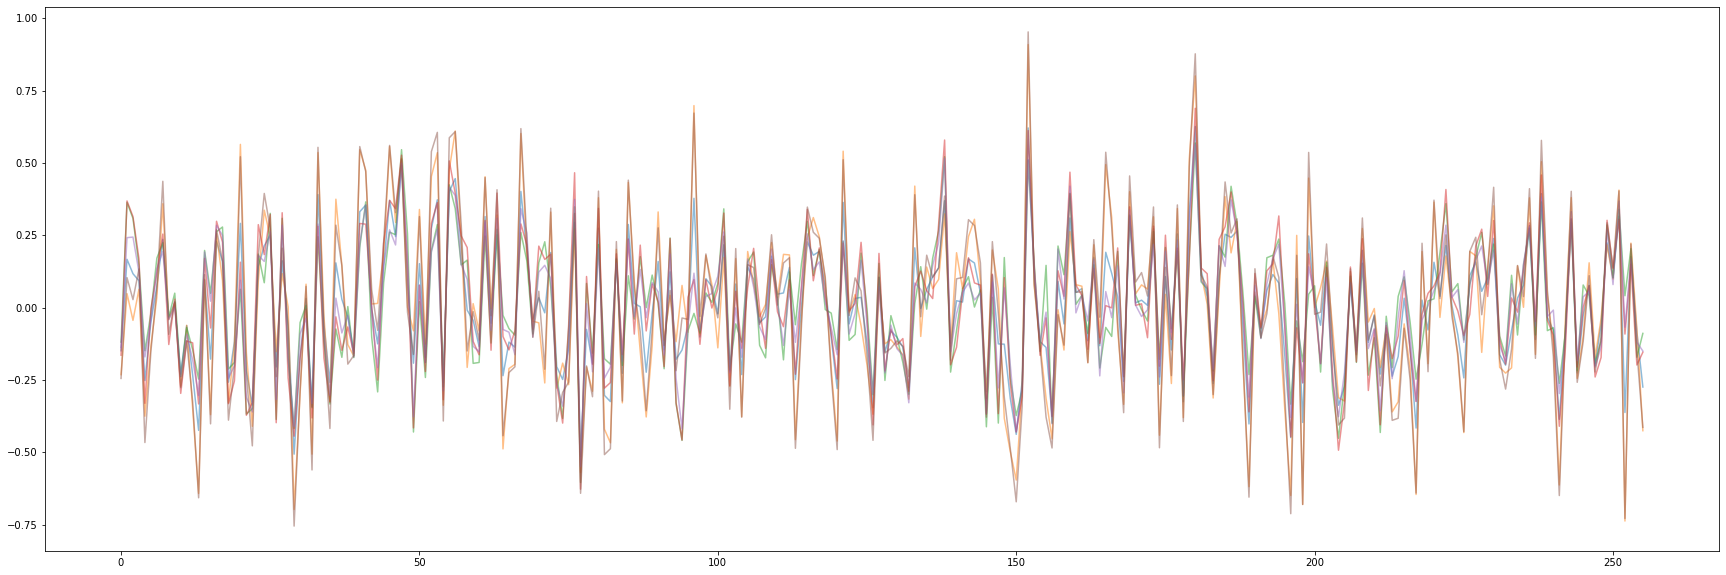

In [380]:
plt.subplots(figsize=(30,10))
plt.plot(e_all.mean(axis=0), alpha=0.5)
for _ in range(0,5):
    i = np.random.choice(e_all.shape[0])
    plt.plot(e_all[i], alpha=0.5)

In [650]:
def heatscatter(a=np.random.normal(size=50_000), b=np.random.normal(size=50_000), bins=100):
    heatmap, xedges, yedges = np.histogram2d(a, b, bins=bins)
    return heatmap

x = np.array([])
y = np.array([])

for _ in range(0,500):
    i = np.random.choice(e_all.shape[0])
    x = np.concatenate((x, e_all.mean(axis=0)))
    y = np.concatenate((y, e_all[i]))
heatmap = heatscatter(x,y, 100) * 1000
heatmap = np.flip(heatmap, axis=0)
fm.viewer(heatmap, 5)
    #plt.scatter(e_all.mean(axis=0), e_all[i], alpha=0.5)

interactive(children=(Dropdown(description='Color', index=10, options=('gray', 'Gators', 'Greens', 'prism', 'v…

In [370]:
np.linalg.norm(e_all.mean(axis=0))

3.3988190427289195

In [372]:
np.mean(np.linalg.norm(e_all, axis=0))

5.784296416597168

In [649]:
def process(mat, n):
    v = mat.copy()
    # Subtract mean.
    v = v - v.mean(axis=0)
    # Fit n PCA components.
    pca = sklearn.decomposition.PCA(n_components=n)
    pca.fit(v)
    # Subtract off the first n components.
    tfm = pca.transform(v)
    print(tfm.shape)
    for i in range(n):
        vp = np.outer(tfm[:,i], pca.components_[i])
        v = v - vp
    print(vp[0])
    return v

# Same, written with vectors. Confirmed output is the same as process.
def process2(mat_in, n):
    mat = mat_in.copy()
    # Subtract mean.
    mat = mat - mat.mean(axis=0)
    # Fit n PCA components.
    pca = sklearn.decomposition.PCA(n_components=n)
    pca.fit(mat)
    # Subtract off the first n components.
    #tfm = pca.transform(v)
    for r in range(mat.shape[0]):
        v = mat[r]
        for i in range(n):
            comp = pca.components_[i]
            #comp = np.expand_dims(comp, 1) # column vector
            vp = np.dot(comp, v)
            vp = vp * comp
            v = v - vp

        mat[r, :] = v
    return mat